In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
cd /content/drive/MyDrive/Selise/

/content/drive/MyDrive/Selise


In [ ]:
ls

dataset_256X256/  dataset_256X256.zip  __MACOSX/  resnet18/


In [ ]:
# !unzip /content/drive/MyDrive/Selise/dataset_256X256.zip

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.model_selection import KFold

In [ ]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    # print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

In [ ]:
path_training_folder= "/content/drive/MyDrive/Selise/dataset_256X256/train"

In [ ]:
transform = transforms.Compose(
        [transforms.CenterCrop(255),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [ ]:
dataset = torchvision.datasets.ImageFolder(root=path_training_folder,transform=transform)

### Creating data indices for training and validation splits:

In [8]:
params = {
    "model": "resnet18",
    "feature_dimension": 512,
    "device": "cuda",
    "lr": 0.001,
    "batch_size": 64,
    "num_workers": 2,
    "epochs": 40,
}

In [ ]:
import numpy as np
from collections import defaultdict

In [ ]:
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)

for fold, (train_indices, val_indices) in enumerate(kfold.split(dataset)):    
    train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
    valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)
        
    trainloader = torch.utils.data.DataLoader(dataset, batch_size=params['batch_size'],
                                                shuffle=False, num_workers=params['num_workers'], sampler=train_sampler)
        
    testloader = torch.utils.data.DataLoader(dataset, batch_size=params['batch_size'],
                                                shuffle=False, num_workers=params['num_workers'], sampler=valid_sampler)

In [ ]:
# train_indices

In [ ]:
# val_indices

### Helpers in training

In [ ]:
# Calculate Accuracy

def calculate_accuracy(output, target):
    return torch.true_divide((target == output).sum(dim=0), output.size(0)).item()

class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

### Creating PT data samplers and loaders:

In [14]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [15]:
class CustomPretrainedModel(nn.Module):
    def __init__(self, model_name=params["model"], feature_dim=params["feature_dimension"], class_number=4):
        super(CustomPretrainedModel, self).__init__()
        self.model_name = model_name
        self.feature_dim = feature_dim
        self.class_number = class_number
        self.ready_model = self.model_return()

    def model_return(self):
        pre_model = getattr(models, self.model_name)(pretrained=True)
        # print(pre_model)
        pre_model.fc = nn.Identity()
        pre_model.fc = nn.Linear(in_features=self.feature_dim, out_features=self.class_number, bias=True)
        return pre_model

    def forward(self, x):
        output = self.ready_model(x)
        return output

In [16]:
ready_model = CustomPretrainedModel()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [17]:
ready_model

CustomPretrainedModel(
  (ready_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [ ]:
# model = getattr(models, params["model"])(pretrained=False, num_classes=4,)
model = ready_model.to(params["device"])
criterion = nn.CrossEntropyLoss().to(params["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])

In [ ]:
classes = ('berry', 'bird', 'dog', 'flower')

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(labels)


torch.Size([64, 3, 255, 255])
tensor([1, 1, 2, 2, 2, 0, 0, 1, 0, 1, 1, 1, 2, 2, 1, 0, 3, 1, 1, 0, 1, 0, 1, 2,
        3, 0, 0, 0, 0, 2, 3, 1, 1, 1, 3, 0, 3, 3, 3, 3, 3, 0, 1, 2, 0, 3, 1, 0,
        2, 1, 3, 2, 1, 2, 3, 3, 0, 0, 3, 2, 0, 3, 2, 0])


Check:   bird -  bird -   dog -   dog -   dog - berry - berry -  bird - berry -  bird -  bird -  bird -   dog -   dog -  bird - berry - flower -  bird -  bird - berry -  bird - berry -  bird -   dog - flower - berry - berry - berry - berry -   dog - flower -  bird -  bird -  bird - flower - berry - flower - flower - flower - flower - flower - berry -  bird -   dog - berry - flower -  bird - berry -   dog -  bird - flower -   dog -  bird -   dog - flower - flower - berry - berry - flower -   dog - berry - flower -   dog - berry


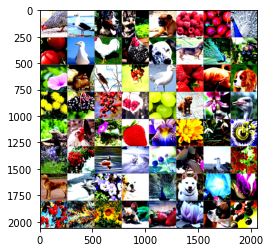

In [ ]:
# print labels
print('Check: ', ' - '.join('%5s' % classes[labels[j]] for j in range(params['batch_size'])))
       

# show images
imshow(torchvision.utils.make_grid(images))

### Training func

In [ ]:
from tqdm import tqdm

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True)
        output = model(images)
        preds = torch.argmax(output, dim=1)
        loss = criterion(output, target)
        accuracy = calculate_accuracy(preds, target)

        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", accuracy)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )
    return metric_monitor.metrics['Loss']['avg'], metric_monitor.metrics['Accuracy']['avg'] #loss.item(), accuracy

### Validation function

In [ ]:
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True)
            output = model(images)
            preds = torch.argmax(output, dim=1)
            loss = criterion(output, target)
            accuracy = calculate_accuracy(preds, target)

            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
          
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )
    return metric_monitor.metrics['Loss']['avg'], metric_monitor.metrics['Accuracy']['avg'] #loss.item(), accuracy

### Saving models

In [ ]:
def model_save(epoch, model, optimizer, PATH):
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
                }, PATH)

### Training loop

In [ ]:
# Define the K-fold Cross Validator
# k_folds = 5
# kfold = KFold(n_splits=k_folds, shuffle=True)
train_losses = []
train_acc = []

val_losses = []
val_acc = []
# fold_count = 0

# for fold, (train_indices, val_indices) in enumerate(kfold.split(dataset)):
#     fold_count += 1
#     print("------------------KFold-------------------", fold_count)
#     train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
#     valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)
    
#     trainloader = torch.utils.data.DataLoader(dataset, batch_size=params['batch_size'],
#                                               shuffle=False, num_workers=params['num_workers'], sampler=train_sampler)
     
#     testloader = torch.utils.data.DataLoader(dataset, batch_size=params['batch_size'],
#                                              shuffle=False, num_workers=params['num_workers'], sampler=valid_sampler)
    

#     ready_model.apply(reset_weights)

    

prev_accuracy = .95
for epoch in range(1, params["epochs"] + 1):
    train_loss, train_accuracy = train(trainloader, model, criterion, optimizer, epoch, params)
    val_loss, val_accuracy = validate(testloader, model, criterion, epoch, params)
    # print("##########", train_loss, val_loss)
    # print("!!!!!!!!!", train_accuracy, val_accuracy)

    if val_accuracy >= prev_accuracy:
        model_save(epoch, model, optimizer, PATH = f"/content/drive/MyDrive/Selise/resnet18/my_model_epoch_{epoch}.pth")

# prev_accuracy = val_accuracy

    train_losses.append(train_loss)
    train_acc.append(train_accuracy)
    val_losses.append(val_loss)
    val_acc.append(val_accuracy)

Epoch: 1. Train.      Loss: 0.349 | Accuracy: 0.879: 100%|██████████| 60/60 [12:25<00:00, 12.42s/it]
Epoch: 1. Validation. Loss: 0.256 | Accuracy: 0.909: 100%|██████████| 15/15 [03:28<00:00, 13.91s/it]
Epoch: 2. Train.      Loss: 0.161 | Accuracy: 0.943: 100%|██████████| 60/60 [00:16<00:00,  3.57it/s]
Epoch: 2. Validation. Loss: 0.278 | Accuracy: 0.901: 100%|██████████| 15/15 [00:04<00:00,  3.62it/s]
Epoch: 3. Train.      Loss: 0.151 | Accuracy: 0.944: 100%|██████████| 60/60 [00:17<00:00,  3.50it/s]
Epoch: 3. Validation. Loss: 0.214 | Accuracy: 0.924: 100%|██████████| 15/15 [00:04<00:00,  3.62it/s]
Epoch: 4. Train.      Loss: 0.072 | Accuracy: 0.975: 100%|██████████| 60/60 [00:16<00:00,  3.59it/s]
Epoch: 4. Validation. Loss: 0.239 | Accuracy: 0.908: 100%|██████████| 15/15 [00:04<00:00,  3.65it/s]
Epoch: 5. Train.      Loss: 0.101 | Accuracy: 0.963: 100%|██████████| 60/60 [00:16<00:00,  3.57it/s]
Epoch: 5. Validation. Loss: 0.180 | Accuracy: 0.947: 100%|██████████| 15/15 [00:04<00:00,  

Training Loss and Validation Loss Curve

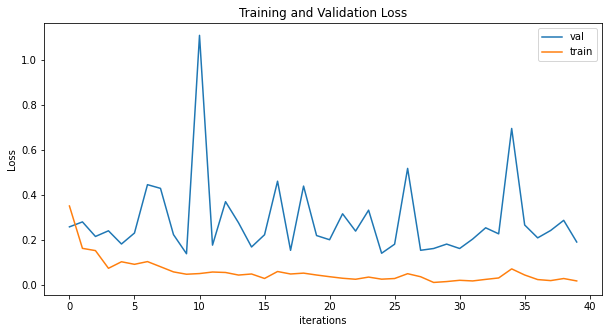

In [ ]:
############ Curve ############
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
# plt.savefig('/content/drive/MyDrive/Selise/resnet18/train_and_val_loss_resnet18.jpg')
plt.show()

Training Loss and Validation Accuracy Curve

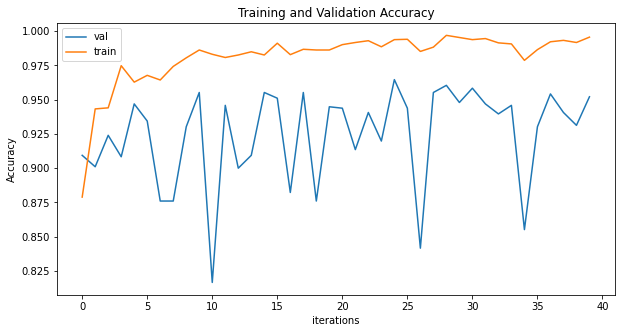

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(val_acc,label="val")
plt.plot(train_acc,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
# plt.savefig('/content/drive/MyDrive/Selise/resnet18/train_and_val_acc_resnet18.jpg')
plt.show()

### Inference pipeline

In [1]:
from sklearn.metrics import f1_score, precision_score

In [ ]:
test_data_folder = "/content/drive/MyDrive/Selise/dataset_256X256/test"

In [4]:
transform = transforms.Compose(
        [transforms.CenterCrop(255),
         transforms.ToTensor(),
         transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [ ]:
test_dataset = torchvision.datasets.ImageFolder(root=test_data_folder,transform=transform)

In [ ]:
inference_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)

In [ ]:
### Calculating matrics

def calculate_metrics(output, target):
    target = target.cpu()
    output = output.cpu()
    
    return torch.true_divide((target == output).sum(dim=0), output.size(0)).item(), f1_score(target, output, average='micro'), precision_score(target, output, average='micro')

In [ ]:
def test(test_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    path = "/content/drive/MyDrive/Selise/resnet18/my_model_epoch_25.pth"
    checkpoint = torch.load(path, map_location=params['device'])
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    model.eval()
    stream = tqdm(test_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True)#.float().view(-1, 1)
            output = model(images)
            preds = torch.argmax(output, dim=1)
            
            accuracy, f1_score_var, precision = calculate_metrics(preds, target)
            
            metric_monitor.update("Accuracy", accuracy)
            metric_monitor.update("F1-Score", f1_score_var)
            metric_monitor.update("Precision-", precision)
            stream.set_description(
                "Epoch: {epoch}. Test. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )
    return accuracy, f1_score

In [ ]:
test_accuracy, _ = test(inference_dataloader, model, criterion, epoch, params)

Epoch: 25. Test. Accuracy: 0.963 | F1-Score: 0.963 | Precision-: 0.963: 100%|██████████| 25/25 [00:08<00:00,  2.83it/s]


### Image Testing

In [5]:
from PIL import Image

In [6]:
def classified_class(output):
    if output[0,0]>output[0,1] and output[0,0]>output[0,2] and output[0,0]>output[0,3]:
      return "Berry"
    elif output[0,1]>output[0,0] and output[0,1]>output[0,2] and output[0,1]>output[0,3]:
      return "Bird"
    elif output[0,2]>output[0,0] and output[0,2]>output[0,1] and output[0,2]>output[0,3]:
      return "Dog"
    elif output[0,3]>output[0,0] and output[0,3]>output[0,1] and output[0,3]>output[0,2]:
      return "Flower"
    else:
      return "Unknown"

In [20]:
model = ready_model.to(params["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])

In [31]:
path = "/content/drive/MyDrive/Selise/resnet18/my_model_epoch_10.pth"
checkpoint = torch.load(path, map_location=params['device'])
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

tensor([[-6.2530,  2.9304, -0.4453,  0.9912]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Bird


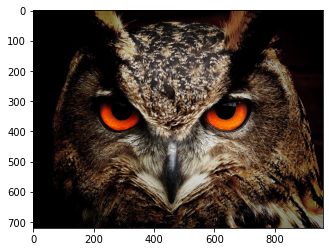

In [32]:
image_for_inference = Image.open('/content/drive/MyDrive/Selise/dataset_256X256/test/owl-50267_960_720.jpg')
# image_for_inference = image_for_inference.resize((32,32))
plt.imshow(image_for_inference)
image_for_inference = transform(image_for_inference)
model.eval()
output = model(image_for_inference.float().unsqueeze(0).to(params["device"], non_blocking=True))
predictions = (torch.sigmoid(output) >= 0.5)[:, 0].cpu().numpy()
print(output)
print(classified_class(output))

Berry


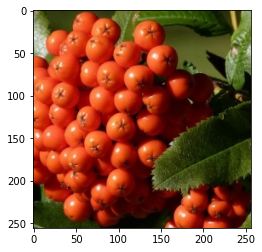

In [33]:
image_for_inference = Image.open('/content/drive/MyDrive/Selise/dataset_256X256/test/berry/134_256.jpg')
# image_for_inference = image_for_inference.resize((32,32))
plt.imshow(image_for_inference)
image_for_inference = transform(image_for_inference)
model.eval()
output = model(image_for_inference.float().unsqueeze(0).to(params["device"], non_blocking=True))
predictions = (torch.sigmoid(output) >= 0.5)[:, 0].cpu().numpy()
print(classified_class(output))

Dog


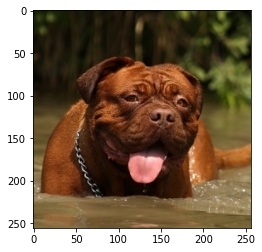

In [43]:
image_for_inference = Image.open('/content/drive/MyDrive/Selise/dataset_256X256/test/dog/104_256.jpg')
# image_for_inference = image_for_inference.resize((32,32))
plt.imshow(image_for_inference)
image_for_inference = transform(image_for_inference)
model.eval()
output = model(image_for_inference.float().unsqueeze(0).to(params["device"], non_blocking=True))
predictions = (torch.sigmoid(output) >= 0.5)[:, 0].cpu().numpy()
print(classified_class(output))

Flower


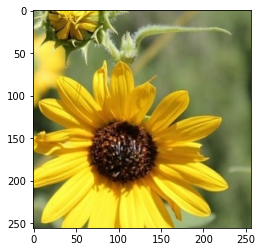

In [35]:
image_for_inference = Image.open('/content/drive/MyDrive/Selise/dataset_256X256/test/flower/130_256.jpg')
# image_for_inference = image_for_inference.resize((32,32))
plt.imshow(image_for_inference)
image_for_inference = transform(image_for_inference)
model.eval()
output = model(image_for_inference.float().unsqueeze(0).to(params["device"], non_blocking=True))
predictions = (torch.sigmoid(output) >= 0.5)[:, 0].cpu().numpy()
print(classified_class(output))